#### Import Modules

In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### Load the data

In [8]:
plt.rcParams.update({'font.size': 30})

<Figure size 640x480 with 0 Axes>

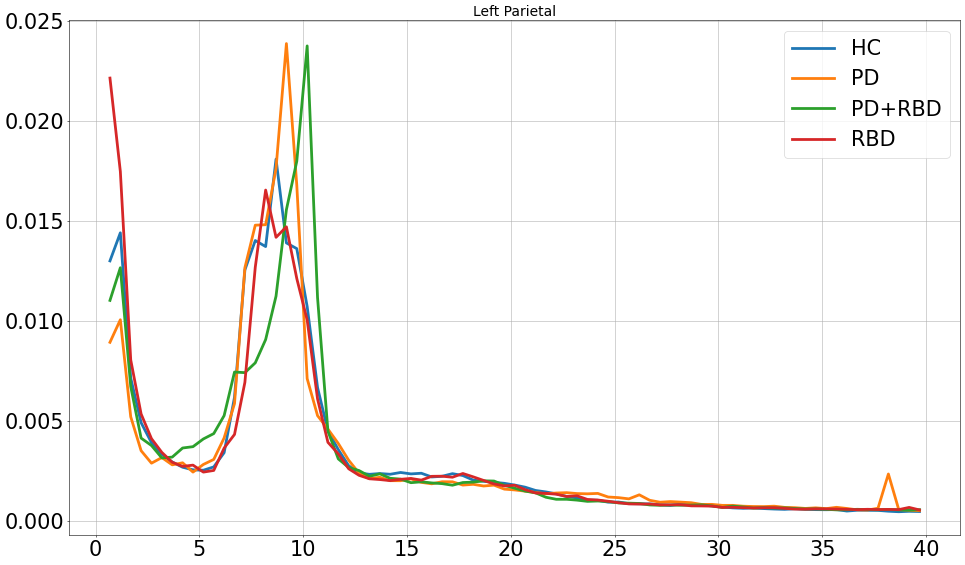

In [15]:
data_types = ['N2', 'N3','REM', 'N1', 'Wake']
factor = 4
num_to_classes = {0: 'HC', 1: 'PD', 2: 'PD+RBD', 3: 'RBD'}

# for data_type in data_types:
for data_type in ['Wake']:
    
    df = joblib.load(data_type + '_psd_normalised_data.pkl')
    
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    paths = joblib.load(folder + data_type + '_paths.pkl')
    
    groups = pd.Series(paths['s_p_id'])
    s_class_list = pd.Series(paths['s_class_list'])
    y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3}) 
    
    df['label'] = y
    
    #Generate a region to features dictionary - this will enable us to run expts regionally as before
    regional_features_dict = {}
    region_channel_dict = constants.region_to_channel_dict
    regions = list(region_channel_dict.keys())
    regions = ['Left Parietal']
    
    for region in regions:
        region_features = [col for col in df.columns if col.endswith('_' + region) ]
        regional_features_dict[region] = region_features
        
    
    
    fig = plt.figure()
    # fig = plt.figure(figsize=(60,50),dpi=100)
    fig = plt.figure(figsize=(20,12),dpi=50)
    
    regional_freq_vals = { 0:[] , 1:[] , 2:[] , 3:[] }
    
    for num, region in enumerate( list(regional_features_dict.keys()) + ['mean'] ) :
        if region!= 'mean':
            region_features = regional_features_dict[region]
            df_region = df[region_features + ['label'] ]
        else:
            continue
    
        # ax = fig.add_subplot(5,3,num+1)
        ax = fig.add_subplot(1,1,num+1)
        plt.title(region , fontsize = 20)
        
        for val in np.unique(df_region['label']):
            if val in [0,1,2,3]:
                frequency_vals  = np.arange(0.5,40.125, 0.125)             
                
                if region == 'mean':
                    psd_values = np.mean(regional_freq_vals[val], axis =0) 
                
                else:
                    mean_psd = df_region[ df_region['label'] == val].drop(columns = ['label']).mean(axis = 0)
                    psd_values = mean_psd.values
                    regional_freq_vals[val].append(psd_values)    
                
                scaled_freq = []
                scaled_psd = []
                
                i = 0
                while i < len(frequency_vals) - factor:
                    scaled_freq.append( frequency_vals[i:i+factor].mean() )
                    scaled_psd.append( psd_values[i:i+factor].mean() )
                    i+= factor
                    
                # plt.yscale("log") 
                plt.plot(scaled_freq, scaled_psd , label = num_to_classes[val], linewidth = '4')
        
        plt.legend()
        plt.grid(which = 'major')
        plt.tight_layout()
        
    # plt.savefig('log_' + data_type +'_factor_' + str(factor) +  '_PSD_Across_Regions.png')
    plt.savefig('PSD_for_presentation.png')